In [1]:
from Lib.BBMetrics import BBMetric
from transformers import TFAutoModelForCausalLM, AutoTokenizer
import os
from Data.data_dicts import character_dict, source_dict, random_state

import os
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    base_folder = '/content/drive/My Drive/unibo/NLP_project/BarneyBot'
    os.system("pip install datasets")
    os.system("pip install transformers")
    os.system("pip install rouge_score")
    os.system("pip install -U sentence-transformers")
else:
    base_folder = os.getcwd()

sentences_basic = ["Hi!", "How are you?", "I hate you."]
sentences_basic_2 = ["Hello!", "How are you doing?", "I think this is good."]
sentences_vader = ["Come to the dark side!", "I will kill you!", "Luke, I am your father."]
sentences_barney = ["Did you get the suit?", "Legendary!", "I like girls."]

In [2]:
model = TFAutoModelForCausalLM.from_pretrained('microsoft/DialoGPT-small', cache_dir=os.path.join(os.getcwd(), "cache"))
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-small', cache_dir=os.path.join(os.getcwd(), "cache"))
tokenizer.pad_token = '#'

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at microsoft/DialoGPT-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [3]:
BBMetric.metrics_list

['bleu',
 'semantic similarity',
 'rouge l',
 'emotion',
 'semantic answer similarity',
 'distinct',
 'semantic classifier',
 'perplexity',
 'human - coherence',
 'human - consistency',
 'human - style']

In [11]:
metric = BBMetric.load_metric("bleu")

print(metric.compute(predictions=sentences_basic, references=sentences_basic_2))

{'score': 0.0, 'std': 0.0}


In [10]:
metric = BBMetric.load_metric("rouge l")

print(metric.compute(predictions=sentences_basic, references=sentences_basic_2))

{'score': 0.36904761904761907, 'std': 0.3599099156626422}


In [14]:
metric = BBMetric.load_metric("distinct")

# ngram_size is optional, defaults to 3
metric.compute(sentences=sentences_basic, ngram_size=2)

{'score': 0.11616161616161617, 'std': 0.0823712445974752}

In [2]:
metric = BBMetric.load_metric("emotion")

print(metric.compute(sentences=sentences_basic))

{'score': [0.04045128605018059, 0.3372649804999431, 0.029534351934368413, 0.33119267721970874, 0.24915542546659708, 0.012401290975200633], 'std': [0.0246632631447857, 0.3520860938584187, 0.03524459240387796, 0.360727083374811, 0.31209396368681236, 0.008284051185361898], 'label': ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']}


In [3]:
print(metric.return_args)

AttributeError: 'BBMetric' object has no attribute 'return_args'

In [16]:
metric = BBMetric.load_metric("semantic similarity")

print(metric.compute(sentences_a=sentences_basic, sentences_b=sentences_basic_2))

{'score': 0.60903007, 'std': 0.40267226}


In [17]:
metric = BBMetric.load_metric("semantic answer similarity")

print(metric.compute(predictions=sentences_basic, references=sentences_basic_2))

{'score': 0.59648186, 'std': 0.4743335}


Loaded encoded lines from D:\University\Esami da Superare\Natural Language Processing\BarneyBot\BarneyBot\Data\Characters\Vader\vader_encoded_lines.npy
Running shuffle 0/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 5054.19it/s]


Running shuffle 1/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 5053.57it/s]


Running shuffle 2/10


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 10111.69it/s]


Running shuffle 3/10


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 10093.67it/s]


Running shuffle 4/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 7136.70it/s]


Running shuffle 5/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 5053.73it/s]


Running shuffle 6/10


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 10098.59it/s]


Running shuffle 7/10


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 10097.52it/s]


Running shuffle 8/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 7144.24it/s]


Running shuffle 9/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 5053.34it/s]


Loading training data...


100%|██████████████████████████████████████████████████████████████████████████████████████| 2686/2686 [00:00<?, ?it/s]


Loading test data...


100%|█████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 20283.73it/s]


Loading validation data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<?, ?it/s]


Epoch 1/1000
168/168 [==============================] - 10s 37ms/step - loss: 1.0083 - binary_accuracy: 0.4907 - recall_1: 0.5071 - val_loss: 0.7657 - val_binary_accuracy: 0.4494 - val_recall_1: 0.8333
Epoch 2/1000
168/168 [==============================] - 6s 35ms/step - loss: 0.9268 - binary_accuracy: 0.5357 - recall_1: 0.5399 - val_loss: 0.8456 - val_binary_accuracy: 0.4620 - val_recall_1: 0.5897
Epoch 3/1000
168/168 [==============================] - 6s 37ms/step - loss: 0.8853 - binary_accuracy: 0.5491 - recall_1: 0.5570 - val_loss: 0.8282 - val_binary_accuracy: 0.5253 - val_recall_1: 0.6282
Epoch 4/1000
168/168 [==============================] - 6s 35ms/step - loss: 0.8468 - binary_accuracy: 0.5730 - recall_1: 0.5735 - val_loss: 0.7944 - val_binary_accuracy: 0.5823 - val_recall_1: 0.6026
Epoch 5/1000
168/168 [==============================] - 6s 35ms/step - loss: 0.7818 - binary_accuracy: 0.6035 - recall_1: 0.6025 - val_loss: 0.7478 - val_binary_accuracy: 0.6076 - val_recall_1: 0

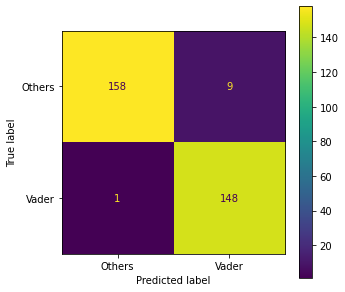

INFO:tensorflow:Assets written to: D:\University\Esami da Superare\Natural Language Processing\BarneyBot\BarneyBot\Data\Characters\Vader\vader_classifier_1000\assets
Using classifier at D:\University\Esami da Superare\Natural Language Processing\BarneyBot\BarneyBot\Data\Characters\Vader\vader_classifier_1000
{'score': 0.3908519, 'std': 0.0}
Using classifier at D:\University\Esami da Superare\Natural Language Processing\BarneyBot\BarneyBot\Data\Characters\Vader\vader_classifier_1000
{'score': 0.57754326, 'std': 0.0}


In [18]:
metric = BBMetric.load_metric("semantic classifier")

# n_shuffles is optional, defaults to 10
# from_saved_embeddings is optional, defaults to True
# shutdown_at_end is optional, defaults to False
# epochs is optional, defaults to 1000
metric.train(character='Vader', character_dict=character_dict, source_dict=source_dict, random_state=random_state,
             base_folder=base_folder, n_shuffles=10, from_saved_embeddings=True, shutdown_at_end=False, epochs=1000)

# from_n_epochs is optional, defaults to 'last'
# n_draws is optional, defaults to len(sentences)-2
print(metric.compute(character='Vader', character_dict=character_dict, base_folder=base_folder, from_n_epochs='last',
               sentences=sentences_basic))
print(metric.compute(character='Vader', character_dict=character_dict, base_folder=base_folder, from_n_epochs='last',
               sentences=sentences_vader))

In [19]:
metric = BBMetric.load_metric("perplexity")

# stride is optional, defaults to 64
print(metric.compute(model=model, tokenizer=tokenizer, sentences=sentences_basic, stride=3))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.75s/it]

{'score_concat': 40623438.20342068}


In [ ]:
metric = BBMetric.load_metric("human - coherence")

# length is optional, defaults to 5
metric.train(model=model, tokenizer=tokenizer,
             filepath=os.path.join(os.getcwd(), "Datasets", "Characters", "Default", "humancoherence.csv"),
             length=2)

metric.compute(filepath=os.path.join(os.getcwd(), "Datasets", "Characters", "Default", "humancoherence.csv"))

In [ ]:
metric = BBMetric.load_metric("human - consistency")

metric.train(model=model, tokenizer=tokenizer,
             filepath=os.path.join(os.getcwd(), "Datasets", "Characters", "Default", "humanconsistency.csv"))

metric.compute(filepath=os.path.join(os.getcwd(), "Datasets", "Characters", "Default", "humanconsistency.csv"))

In [ ]:
metric = BBMetric.load_metric("human - style")

metric.train(model=model, tokenizer=tokenizer,
             filepath=os.path.join(os.getcwd(), "Datasets", "Characters", "Default", "humanstyle.csv"),
             questions=barney_sentences)

metric.compute(filepath=os.path.join(os.getcwd(), "Datasets", "Characters", "Default", "humanstyle.csv"))